In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
    def __init__(self,data, _children=(), _op='', label=''):
        self.data=data
        self.grad=0.0
        self._backward= lambda: None
        self._prev=set(_children)
        self._op=_op
        self.label=label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        out = Value(self.data+other.data, (self,other), '+')

        def _backward():
            self.grad+= 1.0*out.grad
            other.grad+= 1.0*out.grad
        out._backward= _backward
        return out
    
    def __radd__(self,other):
        return self+other
    
    def __neg__(self):
        return self*-1
    
    def __sub__(self,other):
        return self+(-other)
    
    def __mul__(self,other):
        other=other if isinstance(other,Value) else Value(other)
        out = Value(self.data*other.data, (self,other), '*')

        def _backward():
            self.grad+=other.data*out.grad
            other.grad+=self.data*out.grad
        out._backward=_backward
        return out
    
    def __rmul__(self,other):
        return self*other
    
    def __pow__(self,other):
        #other=other if isinstance(other,Value) else Value(other)
        assert isinstance(other, (int,float)),"only int/float powers for now"
        out=Value(self.data**other, (self,), f'**{other}') #make 'other.data' to 'other' if there is bug or  reverse

        def _backward():
            self.grad+=(other*self.data**(other-1))*out.grad  #make 'other.data' to 'other' if there is bug or reverse
        out._backward=_backward

        return out
    
    def __truediv__(self,other):
        return self*other**-1
    
    def exp(self):
        x=self.data
        out=Value(math.exp(x), (self,),'exp')

        def _backward():
            self.grad+=out.data*out.grad
        out._backward=_backward
        return out
    
    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad+=(1-t**2)* out.grad

        out._backward=_backward

        return out
    
    def backward(self):
        topo= []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad=1.0

        for node in reversed(topo):
            node._backward()


In [3]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % ( n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [4]:
#inputs x1,x2
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')
#weights w1,w2
w1=Value(-3.0, label='w1')
w2=Value(1.0, label='w2')
#bias of the neuron
b=Value(6.8813735870195432, label='b')
#x1w1 + x2w2 +b
x1w1=x1*w1; x1w1.label='x1*w1'
x2w2=x2*w2; x2w2.label='x2*w2'
x1w1x2w2=x1w1+x2w2; x1w1x2w2.label='x1*w1 +x2*w2'
n=x1w1x2w2+b; n.label='n'
o = n.tanh(); o.label='o'
o.backward()

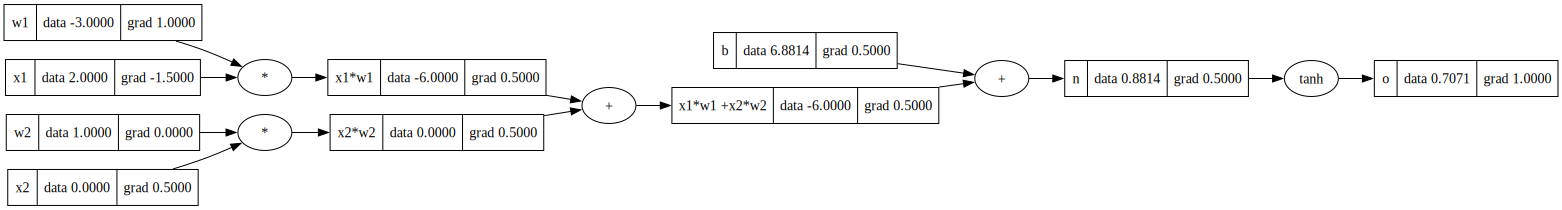

In [5]:
draw_dot(o)

In [6]:
o.backward()

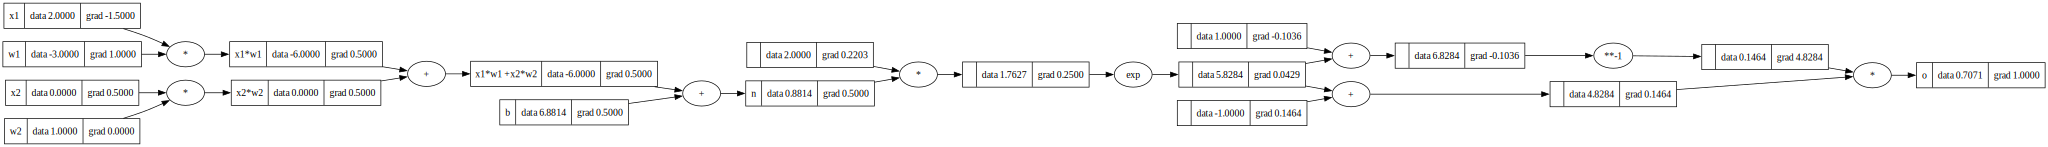

In [7]:
#inputs x1,x2
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')
#weights w1,w2
w1=Value(-3.0, label='w1')
w2=Value(1.0, label='w2')
#bias of the neuron
b=Value(6.8813735870195432, label='b')
#x1w1 + x2w2 +b
x1w1=x1*w1; x1w1.label='x1*w1'
x2w2=x2*w2; x2w2.label='x2*w2'
x1w1x2w2=x1w1+x2w2; x1w1x2w2.label='x1*w1 +x2*w2'
n=x1w1x2w2+b; n.label='n'

e=(2*n).exp()
o=(e-1)/(e+1)
o.label='o'
o.backward()
draw_dot(o)

In [9]:
import torch
import random

In [10]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 3060 Laptop GPU


In [11]:
x1=torch.Tensor([2.0]).double()                         ; x1.requires_grad=True
x2=torch.Tensor([0.0]).double()                         ; x2.requires_grad=True
w1=torch.Tensor([-3.0]).double()                        ; w1.requires_grad=True
w2=torch.Tensor([1.0]).double()                         ; w2.requires_grad=True
b=torch.Tensor([6.8813735870195432]).double()           ; b.requires_grad=True
n=x1*w1+x2*w2+b
o=torch.tanh(n)


print(o.data.item())
o.backward()

print('----')
print('x2',x2.grad.item())
print('w2',w2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [12]:
class Neuron:

    def __init__(self,nin):
        self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b=Value(random.uniform(-1,1))
            
    def __call__(self,x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)), self.b)
        out=act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:

    def __init__(self, nin, nout):
        self.neurons=[Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs=[n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self,nin, nouts):
        sz=[nin]+nouts
        self.layers=[Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        return x   
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [25]:
x=[2.0,3.0, -1.0]
n=MLP(3, [4,4,1])
n(x)

Value(data=-0.40603662138363034)

In [26]:
len(n.parameters())

41

In [27]:
xs=[
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0],
]

ys=[1.0,-1.0,-1.0,1.0] #desired targets


In [30]:
for k in range(40):

    #forward pass
    ypred=[n(x) for x in xs]
    loss = sum ([(yout-ygt)**2 for ygt, yout in zip(ys,ypred)])

    #backward pass
    for p in n.parameters():
        p.grad=0.0
    loss.backward()

    for p in n.parameters():
        p.data += -0.01*p.grad

    print( k, loss.data)


0 0.03273294440045132
1 0.03241087554537552
2 0.03209521322862655
3 0.031785765733868696
4 0.031482348952346265
5 0.031184786009623003
6 0.030892906913989302
7 0.030606548225092692
8 0.030325552741455666
9 0.030049769205644512
10 0.029779052025943744
11 0.029513261013473777
12 0.029252261133766087
13 0.028995922271882586
14 0.028744119010228872
15 0.028496730418272012
16 0.02825363985342884
17 0.028014734772441527
18 0.027779906552604223
19 0.027549050322248265
20 0.027322064799933023
21 0.027098852141827612
22 0.02687931779680245
23 0.026663370368781282
24 0.026450921485934142
25 0.026241885676319496
26 0.026036180249608062
27 0.025833725184545964
28 0.025634443021834225
29 0.025438258762125607
30 0.025245099768854876
31 0.025054895675638587
32 0.024867578297996455
33 0.024683081549160605
34 0.02450134135975458
35 0.024322295601136138
36 0.02414588401221074
37 0.023972048129534046
38 0.023800731220532764
39 0.023631878219682233


In [31]:
ypred

[Value(data=0.9123088671808306),
 Value(data=-0.9218533864121378),
 Value(data=-0.9241191674678042),
 Value(data=0.936145873402393)]

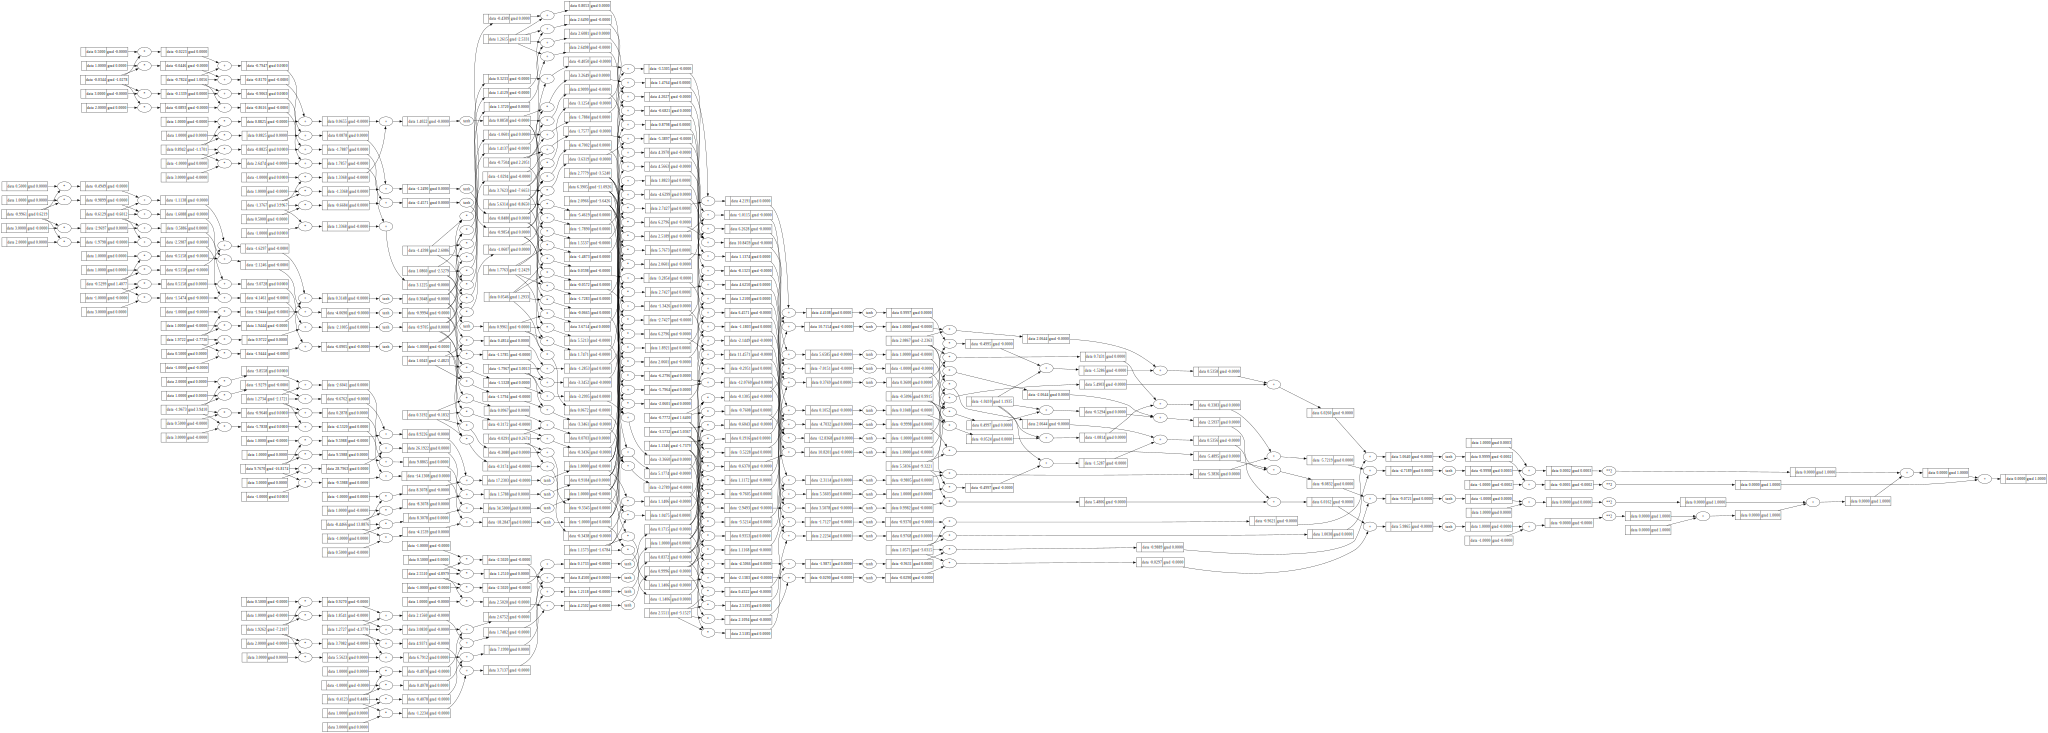

In [187]:
draw_dot(loss)